## Setup

In [1]:
%reload_ext autoreload
%autoreload 2
from termcolor import colored
import dotenv
import sys
import dspy
import os

from tqdm.auto import tqdm

sys.path.append('../pipeline_v2/')
import main
dotenv.load_dotenv('../.env', override=True)

from utils import print_header

import pandas as pd

def print_final_result(statement, verdict, confidence, reasoning, gold_verdict=None):
    # Print final result
    print("\nFinal Fact-Check Result:")
    print_header(f"Statement: {colored(statement, 'white')}", level=1)
    print_header(f"Overall Verdict: {colored(verdict, 'green')}", level=1)
    print_header(f"Overall Confidence: {colored(str(confidence), 'yellow')}", level=1)
    print_header(f"Overall Reasoning: {colored(reasoning, 'cyan')}", level=1)
    if gold_verdict: print_header(f"Gold Verdict: {colored(gold_verdict, 'green')}", level=1)

/opt/homebrew/Caskroom/miniforge/base/envs/RAG/lib/python3.10/site-packages/pydantic/_internal/_config.py:345: UserWarning: Valid config keys have changed in V2:
* 'fields' has been removed
  warnings.warn(message, UserWarning)


In [2]:
# Set custom constants for whole pipeline
main.VERBOSE = True # Print intermediate results
# main.VERDICTS=["Supported", "Refuted", "Not Enough Evidence", "Conflicting Evidence/Cherry-picking"]

# Initialize DSPy
lm = dspy.LM('gemini/gemini-1.5-flash', api_key=os.getenv('GOOGLE_GEMINI_API_KEY'), cache=False)
# lm = dspy.LM('ollama_chat/mistral-custom', api_base='http://localhost:11434', api_key='', cache=False)
# lm = dspy.LM('openrouter/mistralai/mistral-7b-instruct:free', api_key=os.getenv('OPENROUTER_API_KEY'), cache=False)
# lm = dspy.LM('ollama_chat/llama3.1:8b', api_base='http://localhost:11434', api_key='', cache=False)
# lm = dspy.LM('openrouter/meta-llama/llama-3.1-8b-instruct:free', api_key=os.getenv('OPENROUTER_API_KEY'), cache=False)
# lm = dspy.LM('ollama_chat/deepseek-r1:7b', api_base='http://localhost:11434', api_key='', cache=False)
# lm = dspy.LM('openrouter/deepseek/deepseek-r1-distill-llama-70b:free', api_key=os.getenv('OPENROUTER_API_KEY'), cache=False)
# lm = dspy.LM('openrouter/deepseek/deepseek-r1:free', api_key=os.getenv('OPENROUTER_API_KEY'), cache=False)
dspy.settings.configure(lm=lm, temperature=0.3)

pipeline_val = main.FactCheckPipeline(
    # search_provider=main.SearchProvider(provider="duckduckgo"),
    search_provider=main.SearchProvider(provider="serper", api_key=os.getenv('SERPER_API_KEY')),
    model_name=lm,
    embedding_model=main.EMBEDDING_MODEL,
    retriever_k=5
)

In [78]:
### Load data
if os.path.exists('results_v2.pkl'):
    df = pd.read_pickle('results_v2.pkl')
else: 
    df = pd.read_csv('../data/pilot_updated_v2.csv')

    # # Drop unneeded columns
    df.drop(columns=['Assignee', 'questions to verify the statement', 'Gold Label', 'factcheck_date'], inplace=True)

    # Reformat dates
    df['statement_date'] = pd.to_datetime(df['statement_date']).dt.strftime("%B %d, %Y")

# df

[autoreload of main failed: Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/RAG/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/RAG/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/RAG/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/RAG/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 365, in update_class
    update_instances(old, new)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/RAG/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 319, in update_instances
    refs = gc.get_referrers(old)
KeyboardInterrupt
]


## Search Testing

In [6]:
pipeline_val.search_provider.search('what is the capital of France?')

         Retrieved 5 Sources: 
           1. Paris - Wikipedia 
           URL: https://en.wikipedia.org/wiki/Paris 
           Excerpt: Paris is the capital and largest city of France. With an estimated population of 2,048,472 residents in January 2025 in an area of more than 105 km2 (41 sq ... 
           2. Paris, France - Intercultural City - The Council of Europe 
           URL: https://www.coe.int/en/web/interculturalcities/paris 
           Excerpt: Paris is the capital and most populous city of France. Situated on the Seine River, in the north of the country, it is in the centre of the Île-de-France ... 
           3. Paris facts: the capital of France in history 
           URL: https://home.adelphi.edu/~ca19535/page%204.html 
           Excerpt: Paris is the capital of France, the largest country of Europe with 550 000 km2 (65 millions inhabitants). Paris has 2.234 million inhabitants end 2011 ... 
           4. Paris | Definition, Map, Population, Facts, & History | Britann

[SearchResult(title='Paris - Wikipedia', url='https://en.wikipedia.org/wiki/Paris', source='en.wikipedia.org', excerpt='Paris is the capital and largest city of France. With an estimated population of 2,048,472 residents in January 2025 in an area of more than 105 km2 (41 sq ...', timestamp=None),
 SearchResult(title='List of capitals of France - Wikipedia', url='https://en.wikipedia.org/wiki/List_of_capitals_of_France', source='en.wikipedia.org', excerpt='The capital of France has been Paris since its liberation in 1944.', timestamp=None),
 SearchResult(title='Paris | Definition, Map, Population, Facts, & History | Britannica', url='https://www.britannica.com/place/Paris', source='www.britannica.com', excerpt="Paris, city and capital of France, located along the Seine River, in the north-central part of the country. Paris is one of the world's most important and ...", timestamp=None),
 SearchResult(title='Paris, France - Intercultural City - The Council of Europe', url='https://www.co

In [ ]:
from duckduckgo_search import DDGS
from itertools import cycle

proxy_pool = """
143.107.199.248:8080
""".strip().split('\n')
# 98.80.66.1:10018

proxy_cycle = cycle(proxy_pool)

headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
}

def get_results_with_rotation(query, num_results):
    while True:
        current_proxy = next(proxy_cycle)
        try:
            with DDGS(proxy={'http': current_proxy, 'https': current_proxy}, headers=headers) as ddgs:
                results = ddgs.text(query.lower(), max_results=num_results)
            print(f"Success with proxy {current_proxy}")
            return results
        except Exception as e:
            print(f"Error with proxy {current_proxy}: {e}")
            continue

get_results_with_rotation('google stock price', 10)

## Pipeline

In [7]:
# Test with a single statement from dataset
index = 35
statement = df.iloc[index]['statement']
statement_originator = df.iloc[index]['statement_originator']
statement_date = df.iloc[index]['statement_date']
gold_verdict = df.iloc[index]['verdict']

pipeline_val.retriever.clear()
verdict, confidence, reasoning, claims = pipeline_val.fact_check(
    # statement=f"According to {statement_originator} on {statement_date}, {statement}", 
    statement=f"On {statement_date}, {statement_originator} claimed: {statement}", 
    # statement=statement, 
    # context=f"Statement Originator: {statement_originator}, Date Claim Was Made: {statement_date}"
)
print_final_result(statement, verdict, confidence, reasoning, gold_verdict)

===== Starting Fact Check Pipeline =====
 Original Statement: On August 15, 2024, Julie Su claimed: “400,000 workers are now in a union that were not in a union when (Biden) became president.” 
  ===== Atomic Claim Extraction =====
   Extracted Claims (1):  
     1. On August 15, 2024, Julie Su claimed that 400,000 workers are now in a union that were not in a union when Biden became president. 
===== Breakdown of Claims and Components =====
   Claim 1 
     Text: On August 15, 2024, Julie Su claimed that 400,000 workers are now in a union that were not in a union when Biden became president. 
     Verdict: UNVERIFIABLE 
     Confidence: 1.0 
     Reasoning: The claim states that 400,000 workers joined unions since Biden's inauguration.  The provided QA pairs do not offer the necessary data to verify this claim.  While the data indicates a decrease in union membership in 2021 and provides the union membership rate for 2022, it lacks the total number of union members at the time of Bide

In [ ]:
lm.inspect_history(n=10)

In [ ]:
model = 'gemini-1.5-pro'
num_trials = 3

# If column doesn't exist, create it
if f'{model}_results' not in df.columns: df[f'{model}_results'] = None
df[f'{model}_results'] = df[f'{model}_results'].astype(object)

for index in tqdm(range(len(df))):
    # If results already exist, skip if num_trials is reached
    if df.loc[index, f'{model}_results'] is not None: 
        if len(df.loc[index, f'{model}_results']) == num_trials:
            continue
        else:
            results = df.loc[index, f'{model}_results']
    else: 
        results = []

    for trial_i in tqdm(range(num_trials), leave=False):
        statement = df.iloc[index]['statement']
        statement_originator = df.iloc[index]['statement_originator']
        statement_date = df.iloc[index]['statement_date']
        gold_verdict = df.iloc[index]['verdict']

        verdict, confidence, reasoning, claims = pipeline_val.fact_check(
            statement=statement, 
            context=f"Statement Originator: {statement_originator}, Date Claim Was Made: {statement_date}"
        )
        results.append({
            'verdict': verdict,
            'confidence': confidence,
            'reasoning': reasoning,
            'claims': claims
        })

        print_final_result(statement, verdict, confidence, reasoning, gold_verdict)

    # Update the dataframe
    df.at[index, f'{model}_results'] = results

In [11]:
df.to_pickle('results_v2.pkl')

## Baseline

In [40]:
 class StatementFactCheckerSignature(dspy.Signature):
    f"""Fact check the given statement into one of the following verdicts: {", ".join(main.VERDICTS)}"""
    statement = dspy.InputField(desc="Statement to evaluate")
    verdict = dspy.OutputField(desc=f"Truthful classification of the statement into one of the following verdicts: {', '.join(main.VERDICTS)}")

class StatementFactChecker(dspy.Module):
    def __init__(self):
        super().__init__()
        self.fact_check = dspy.ChainOfThought(StatementFactCheckerSignature)

    def forward(self, statement: str):
        result = self.fact_check(statement=statement)
        verdict = result["verdict"]
        reasoning = result["reasoning"]
        return verdict, reasoning
    

In [ ]:
# Test with a single statement from dataset
index = 4
statement = df.iloc[index]['statement']
statement_originator = df.iloc[index]['statement_originator']
statement_date = df.iloc[index]['statement_date']
gold_verdict = df.iloc[index]['verdict']

fact_checker = StatementFactChecker()
verdict, reasoning = fact_checker(f"On {statement_date}, {statement_originator} claimed: {statement}")
print_final_result(statement, verdict, 1, reasoning, gold_verdict)


Final Fact-Check Result:
   Statement: “The Universities of Wisconsin are 43rd out of 50 states in the nation, in terms of public support for our universities. The $855 million (budget request) gets us up to average.” 
   Overall Verdict: MOSTLY FALSE 
   Overall Confidence: 1 
   Overall Reasoning: Jay Rothman's claim that the Universities of Wisconsin rank 43rd out of 50 states in terms of public support needs verification. Recent data suggests that Wisconsin's public universities are not typically ranked that low. Additionally, the assertion that a $855 million budget request would bring funding up to average requires context about current funding levels and how this amount compares to other states. 
   Gold Verdict: TRUE 


## Analysis

In [11]:
import pandas as pd

model = "gemini"
# model = "mistral"

# df = pd.read_pickle(f'results_v2_{model}_0.pkl')
df = pd.read_pickle(f'results_v2_{model}.pkl')

df['verdict'] = df['verdict'].replace({'PANTS ON FIRE': 'FALSE'})

if f'{model}_results' in df.columns:
    df.rename(columns={f'{model}_results': f'{model}_pipeline_results'}, inplace=True)

VERDICTS = ["TRUE", "MOSTLY TRUE", "HALF TRUE", 
            "MOSTLY FALSE", "FALSE", "UNVERIFIABLE"]

# Extract the verdicts from the gemini_results column
df['pred_verdicts_baseline'] = df[f'{model}_baseline_results'].apply(lambda x: [result['verdict'] for result in x] if x else None)
df['pred_verdicts_pipeline'] = df[f'{model}_pipeline_results'].apply(lambda x: [result['verdict'] for result in x] if x else None)

# Make new column that checks if the true verdict is in the top 3 of the model's verdicts
# df['pred_verdicts_baseline_top3'] = df.apply(lambda row: row['verdict'] in row['pred_verdicts_baseline'][:3], axis=1)
# df['pred_verdicts_pipeline_top3'] = df.apply(lambda row: row['verdict'] in row['pred_verdicts_pipeline'][:3], axis=1)

# Clean up verdicts with extraneous text (not the cleanest/fastest method but it works)
# "UNVERIFIABLE (as of the time of writing, the statement cannot be definitively verified or refuted)": 0,
# 'UNVERIFIABLE (as of now)': 0,
# 'MOSTLY FALSE (for the first claim) and FALSE (for the second claim)': 2,
# 'MOSTLY TRUE - Kelly Ayotte accurately mentioned a relevant bill regarding sanctuary states, but it is unclear if Joyce Craig opposed the bill since she was no longer in office when it was introduced.': 4,
for i, row in df.iterrows():
    cols = ['pred_verdicts_baseline', 'pred_verdicts_pipeline']
    for col in cols: 
        verdicts = row[col]
        if verdicts:
            verdicts = [v.split(':')[0].split('-')[0].split('(')[0].strip() if len(v) > 12 else v for v in verdicts]
        df.at[i, col] = verdicts

df.dropna(subset=['pred_verdicts_pipeline', 'pred_verdicts_baseline'], inplace=True)

df[['verdict', 'pred_verdicts_baseline', 'pred_verdicts_pipeline']]

,verdict,pred_verdicts_baseline,pred_verdicts_pipeline
0,MOSTLY TRUE,"[MOSTLY TRUE, MOSTLY TRUE, UNVERIFIABLE]","[MOSTLY TRUE, MOSTLY TRUE, MOSTLY TRUE]"
1,TRUE,"[MOSTLY TRUE, MOSTLY TRUE, MOSTLY TRUE]","[TRUE, TRUE, TRUE]"
2,FALSE,"[UNVERIFIABLE, UNVERIFIABLE, UNVERIFIABLE]","[FALSE, UNVERIFIABLE, UNVERIFIABLE]"
3,HALF TRUE,"[UNVERIFIABLE, UNVERIFIABLE, UNVERIFIABLE]","[MOSTLY FALSE, MOSTLY TRUE, UNVERIFIABLE]"
4,TRUE,"[UNVERIFIABLE, UNVERIFIABLE, UNVERIFIABLE]","[MOSTLY TRUE, MOSTLY TRUE, MOSTLY TRUE]"
...,...,...,...
77,UNVERIFIABLE,"[UNVERIFIABLE, UNVERIFIABLE, UNVERIFIABLE]","[TRUE, MOSTLY TRUE, MOSTLY TRUE]"
78,UNVERIFIABLE,"[FALSE, FALSE, FALSE]","[FALSE, FALSE, FALSE]"
79,HALF TRUE,"[UNVERIFIABLE, UNVERIFIABLE, UNVERIFIABLE]","[MOSTLY TRUE, MOSTLY FALSE, MOSTLY TRUE]"
80,FALSE,"[FALSE, FALSE, FALSE]","[MOSTLY FALSE, MOSTLY FALSE, MOSTLY FALSE]"


In [12]:
# Fix cases where pipeline returns UNVERIFIABLE 3 times

# df_pkl = pd.read_pickle(f'results_v2_{model}.pkl')

# for i, row in df.iterrows():
#     if row['pred_verdicts_pipeline'] == ['UNVERIFIABLE', 'UNVERIFIABLE', 'UNVERIFIABLE']:
#         print(i)
#         df_pkl.at[i, f'{model}_pipeline_results'] = None


# # df_pkl.to_pickle(f'results_v2_{model}.pkl')

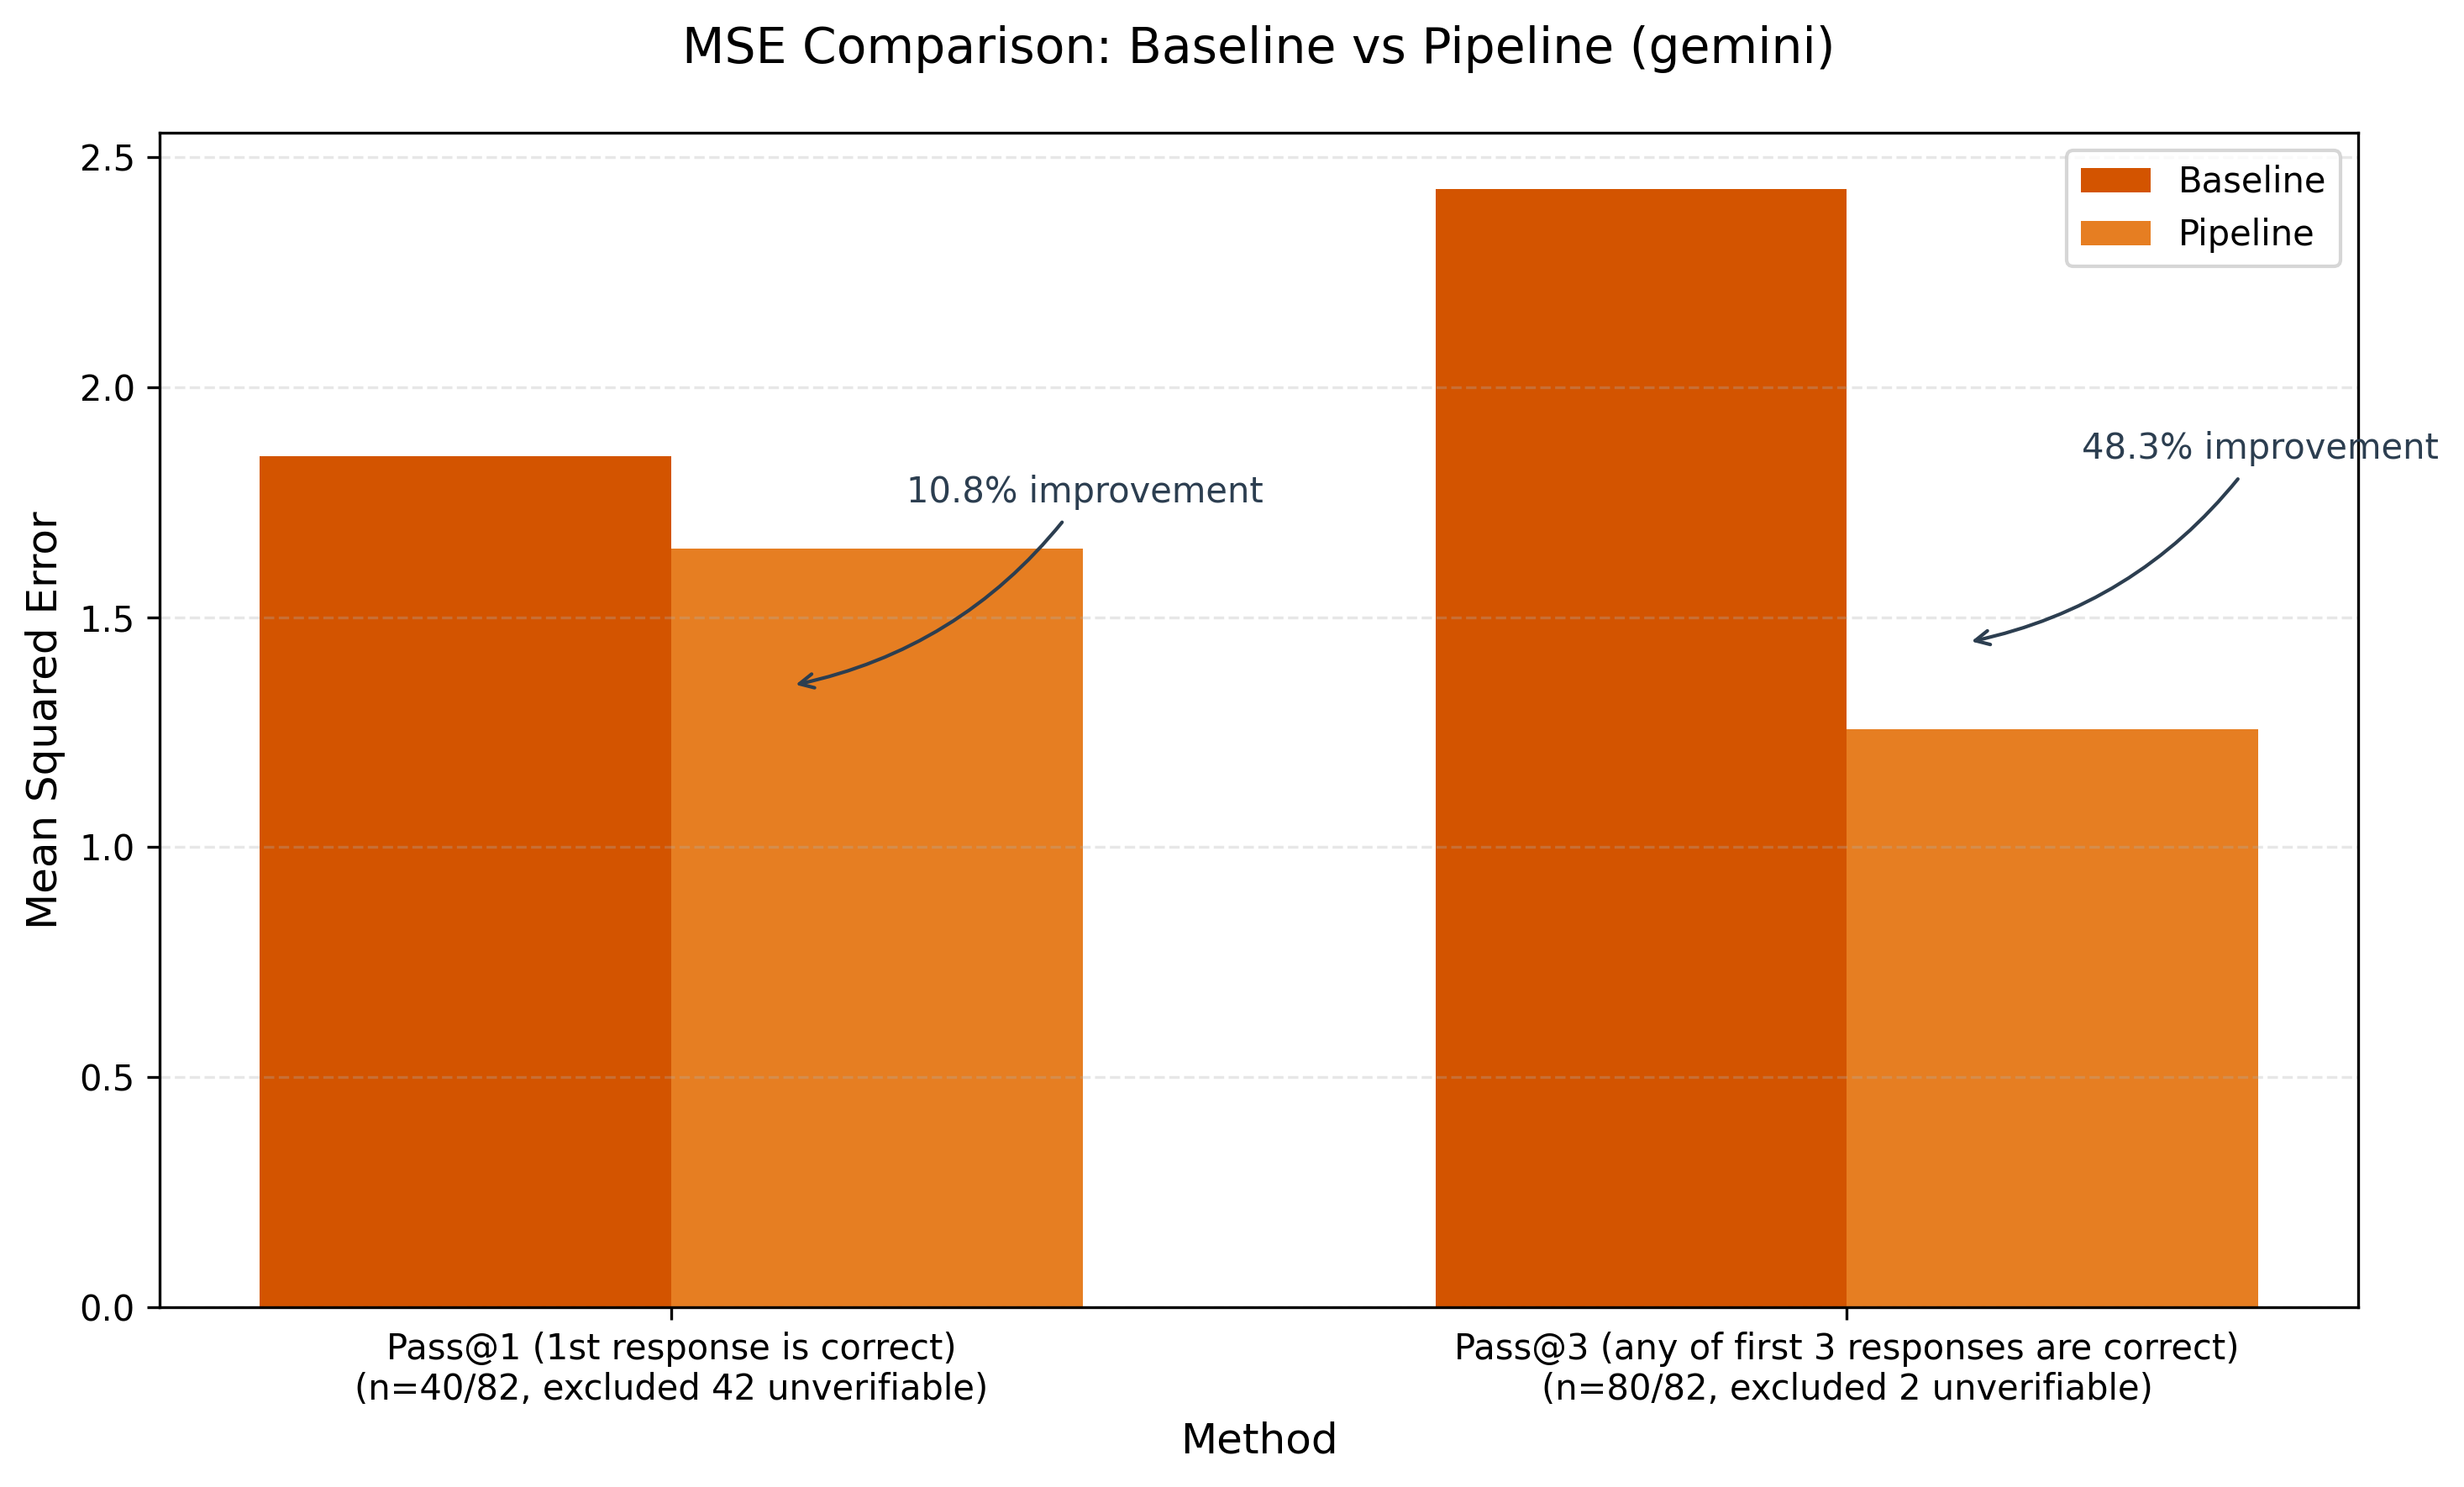

In [13]:
## ANALYSIS EXCLUDING UNVERIFIABLE
import numpy as np
import matplotlib.pyplot as plt

# Calculate ordinal metrics (just MSE for now)
ordinal_metrics = {}

# Define the ordinal mapping
VERDICT_MAP = {
    "TRUE": 5,
    "MOSTLY TRUE": 4,
    "HALF TRUE": 3,
    "MOSTLY FALSE": 2,
    "FALSE": 1,
    "UNVERIFIABLE": 0,
    # Weird cases
    "MOSTLY UNVERIFIABLE": 0,}

# Convert verdicts to numeric values
true_verdicts = [VERDICT_MAP[v] for v in df['verdict']]

# Calculate pass@1 errors
pass1_errors = []
for i in range(len(df)):
    baseline_pred = df['pred_verdicts_baseline'][i][0]
    pipeline_pred = df['pred_verdicts_pipeline'][i][0]
    
    # Skip if either prediction is UNVERIFIABLE
    if baseline_pred == "UNVERIFIABLE" or pipeline_pred == "UNVERIFIABLE":
        continue
        
    true_val = true_verdicts[i]
    baseline_val = VERDICT_MAP[baseline_pred]
    pipeline_val = VERDICT_MAP[pipeline_pred]
    
    pass1_errors.append({
        'baseline': (true_val - baseline_val) ** 2,
        'pipeline': (true_val - pipeline_val) ** 2
    })

# Calculate pass@3 errors
pass3_errors = []
for i in range(len(df)):
    true_val = true_verdicts[i]
    
    # Get non-UNVERIFIABLE predictions
    baseline_preds = [VERDICT_MAP[p] for p in df['pred_verdicts_baseline'][i] if p != "UNVERIFIABLE"]
    pipeline_preds = [VERDICT_MAP[p] for p in df['pred_verdicts_pipeline'][i] if p != "UNVERIFIABLE"]
    
    # Skip only if both have no valid predictions
    if len(baseline_preds) == 0 and len(pipeline_preds) == 0:
        continue
        
    # Calculate errors using best non-UNVERIFIABLE prediction if available, otherwise use None
    baseline_error = min([(p - true_val)**2 for p in baseline_preds]) if baseline_preds else None
    pipeline_error = min([(p - true_val)**2 for p in pipeline_preds]) if pipeline_preds else None
    
    pass3_errors.append({
        'baseline': baseline_error,
        'pipeline': pipeline_error
    })

# Calculate MSE for each case, filtering out None values
ordinal_metrics['baseline_pass@1_mse'] = np.mean([e['baseline'] for e in pass1_errors])
ordinal_metrics['pipeline_pass@1_mse'] = np.mean([e['pipeline'] for e in pass1_errors])
ordinal_metrics['baseline_pass@3_mse'] = np.mean([e['baseline'] for e in pass3_errors if e['baseline'] is not None])
ordinal_metrics['pipeline_pass@3_mse'] = np.mean([e['pipeline'] for e in pass3_errors if e['pipeline'] is not None])

# Plot results and show % improvement (from baseline to pipeline, for both pass@1 and pass@3)
plt.figure(figsize=(10, 6), dpi=300)

# Define fall colors
colors = ['#D35400', '#E67E22']  # Deep orange and lighter orange
bar_width = 0.35
index = np.arange(2)  # Two groups for Pass@1 and Pass@3

# Create bars
baseline_bars = plt.bar(index - bar_width/2, 
                       [ordinal_metrics['baseline_pass@1_mse'], ordinal_metrics['baseline_pass@3_mse']], 
                       bar_width, label='Baseline', color=colors[0])
pipeline_bars = plt.bar(index + bar_width/2, 
                       [ordinal_metrics['pipeline_pass@1_mse'], ordinal_metrics['pipeline_pass@3_mse']], 
                       bar_width, label='Pipeline', color=colors[1])

# Customize the plot
plt.xlabel('Method', fontsize=12)
plt.ylabel('Mean Squared Error', fontsize=12)
plt.title(f'MSE Comparison: Baseline vs Pipeline ({model})', fontsize=14, pad=20)
plt.xticks(index, [
    '\n'.join([
        "Pass@1 (1st response is correct)",
        f"(n={len(pass1_errors)}/{len(df)}, excluded {len(df)-len(pass1_errors)} unverifiable)"
    ]),
    '\n'.join([
        "Pass@3 (any of first 3 responses are correct)",
        f"(n={len(pass3_errors)}/{len(df)}, excluded {len(df)-len(pass3_errors)} unverifiable)"
    ])
])
plt.legend()

# Add improvement arrows and percentages
for idx, (baseline_val, pipeline_val) in enumerate([
    (ordinal_metrics['baseline_pass@1_mse'], ordinal_metrics['pipeline_pass@1_mse']),
    (ordinal_metrics['baseline_pass@3_mse'], ordinal_metrics['pipeline_pass@3_mse'])
]):
    improvement = ((baseline_val - pipeline_val) / baseline_val * 100)
    
    # Draw arrow
    mid_height = (baseline_val + pipeline_val) / 2
    plt.annotate(
        f'{improvement:.1f}% improvement', 
        xy=(idx + 0.1, mid_height - 0.4),
        xytext=(idx + 0.2, mid_height),
        fontsize=10,
        color='#2C3E50',  # Dark blue-gray
        arrowprops=dict(
            arrowstyle='->',
            color='#2C3E50',
            connectionstyle='arc3,rad=-0.2'
        )
    )

# Add grid for better readability
plt.grid(True, axis='y', linestyle='--', alpha=0.3)

# Adjust layout
plt.tight_layout()

In [40]:
# ## ANALYSIS WITHOUT EXCLUDED UNVERIFIABLE
# import numpy as np
# import matplotlib.pyplot as plt

# # Calculate ordinal metrics (just MSE for now)
# ordinal_metrics = {}

# # Define the ordinal mapping
# VERDICT_MAP = {
#     "TRUE": 5,
#     "MOSTLY TRUE": 4,
#     "HALF TRUE": 3,
#     "MOSTLY FALSE": 2,
#     "FALSE": 1,
#     "UNVERIFIABLE": 0,
#     # Weird cases
#     "MOSTLY UNVERIFIABLE": 0,}

# # Convert verdicts to numeric values
# true_verdicts = [VERDICT_MAP[v] for v in df['verdict']]

# for benchmark in ['baseline', 'pipeline']:
#     col = f'pred_verdicts_{benchmark}'

#     # pass@1: calculate MSE using ONLY the first trial prediction
#     first_preds = [VERDICT_MAP[pred_list[0]] for pred_list in df[col]]
#     ordinal_metrics[f'{benchmark}_pass@1_mse'] = np.mean((np.array(true_verdicts) - np.array(first_preds)) ** 2)
    
#     # pass@3: calculate MSE using best prediction across all 3 trials
#     best_preds = [] 
#     for i, pred_list in enumerate(df[col]): # for each 
#         true_verdict = true_verdicts[i] # Get true verdict

#         # Convert predictions to numeric values
#         pred_nums = [VERDICT_MAP[pred] for pred in pred_list]
        
#         # Find prediction with smallest error
#         errors = [(pred - true_verdict)**2 for pred in pred_nums]
#         best_pred = pred_nums[np.argmin(errors)]
#         best_preds.append(best_pred)
        
#     ordinal_metrics[f'{benchmark}_pass@3_mse'] = np.mean((np.array(true_verdicts) - np.array(best_preds)) ** 2)

# # Plot results and show % improvement (from baseline to pipeline, for both pass@1 and pass@3)
# plt.figure(figsize=(10, 6), dpi=300)

# # Define fall colors
# colors = ['#D35400', '#E67E22']  # Deep orange and lighter orange
# bar_width = 0.35
# index = np.arange(2)  # Two groups for Pass@1 and Pass@3

# # Create bars
# baseline_bars = plt.bar(index - bar_width/2, 
#                        [ordinal_metrics['baseline_pass@1_mse'], ordinal_metrics['baseline_pass@3_mse']], 
#                        bar_width, label='Baseline', color=colors[0])
# pipeline_bars = plt.bar(index + bar_width/2, 
#                        [ordinal_metrics['pipeline_pass@1_mse'], ordinal_metrics['pipeline_pass@3_mse']], 
#                        bar_width, label='Pipeline', color=colors[1])

# # Customize the plot
# plt.xlabel('Evaluation Metric', fontsize=12)
# plt.ylabel('Mean Squared Error', fontsize=12)
# plt.title(f'MSE Comparison: Baseline vs Pipeline ({model})', fontsize=14, pad=20)
# plt.xticks(index, ["Pass@1\n(1st response is correct)", "Pass@3\n(any of first 3 responses are correct)"])
# plt.legend()

# # Add improvement arrows and percentages
# for idx, (baseline, pipeline) in enumerate([
#     (ordinal_metrics['baseline_pass@1_mse'], ordinal_metrics['pipeline_pass@1_mse']),
#     (ordinal_metrics['baseline_pass@3_mse'], ordinal_metrics['pipeline_pass@3_mse'])
# ]):
#     improvement = ((baseline - pipeline) / baseline * 100)
    
#     # Draw arrow
#     mid_height = (baseline + pipeline) / 2
#     plt.annotate(
#         f'{improvement:.1f}% improvement', 
#         xy=(idx + 0.1, mid_height - 0.4),
#         xytext=(idx + 0.2, mid_height),
#         fontsize=10,
#         color='#2C3E50',  # Dark blue-gray
#         arrowprops=dict(
#             arrowstyle='->',
#             color='#2C3E50',
#             connectionstyle='arc3,rad=-0.2'
#         )
#     )

# # Add grid for better readability
# plt.grid(True, axis='y', linestyle='--', alpha=0.3)

# # Adjust layout
# plt.tight_layout()

In [176]:
# from sklearn.metrics import confusion_matrix

# def get_first_predictions(prediction_list):
#     """Extract first prediction from each trial list"""
#     return [pred_list[0] for pred_list in prediction_list]

# def create_confusion_matrices(df):
#     """Generate and plot confusion matrices for both models"""
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
    
#     for idx, model in enumerate(['baseline', 'pipeline']):
#         first_preds = get_first_predictions(df[f'pred_verdicts_{model}'])
#         cm = confusion_matrix(df['verdict'], first_preds, labels=VERDICTS)
        
#         # Normalize confusion matrix
#         cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
#         sns.heatmap(cm_norm, annot=True, fmt='.2f', 
#                    xticklabels=VERDICTS, yticklabels=VERDICTS,
#                    ax=[ax1, ax2][idx], cmap='YlOrRd')
#         [ax1, ax2][idx].set_title(f'{model.capitalize()} Model Confusion Matrix')
#         [ax1, ax2][idx].set_xticklabels(VERDICTS, rotation=45)
        
#     plt.tight_layout()
#     return fig

# def analyze_consistency(df):
#     """Analyze model consistency across trials"""
#     consistency_metrics = {}
    
#     for model in ['baseline', 'pipeline']:
#         pred_col = f'pred_verdicts_{model}'
        
#         # Calculate percentage of consistent predictions across trials
#         consistency = df[pred_col].apply(lambda x: len(set(x)) == 1)
#         consistency_metrics[f'{model}_consistency'] = consistency.mean()
        
#         # Analyze most common disagreements
#         disagreements = df[~consistency][['verdict', pred_col]].copy()
#         disagreements['prediction_set'] = disagreements[pred_col].apply(lambda x: tuple(sorted(set(x))))
        
#         # Count most common disagreement patterns
#         consistency_metrics[f'{model}_common_disagreements'] = disagreements['prediction_set'].value_counts().head()
    
#     return consistency_metrics

# def analyze_performance_by_category(df):
#     """Analyze performance on different verdict categories"""
#     fig, axes = plt.subplots(2, 1, figsize=(12, 10))
    
#     # Clear cases (TRUE/FALSE) vs nuanced cases
#     clear_cases = df[df['verdict'].isin(['TRUE', 'FALSE'])]
#     nuanced_cases = df[df['verdict'].isin(['MOSTLY TRUE', 'MOSTLY FALSE', 'HALF TRUE'])]
    
#     for idx, (cases, title) in enumerate([(clear_cases, 'Clear Cases'), 
#                                         (nuanced_cases, 'Nuanced Cases')]):
#         accuracy_data = []
#         for model in ['baseline', 'pipeline']:
#             first_preds = get_first_predictions(cases[f'pred_verdicts_{model}'])
#             accuracy = (cases['verdict'] == first_preds).mean()
#             accuracy_data.append({'Model': model.capitalize(), 'Accuracy': accuracy})
        
#         accuracy_df = pd.DataFrame(accuracy_data)
#         sns.barplot(data=accuracy_df, x='Model', y='Accuracy', ax=axes[idx])
#         axes[idx].set_title(f'Accuracy on {title}')
#         axes[idx].set_ylim(0, 1)
    
#     plt.tight_layout()
#     return fig

# def generate_summary_report(df):
#     """Generate comprehensive analysis report"""
#     # Calculate all metrics
#     # ordinal_metrics = calculate_ordinal_metrics(df)
#     consistency_metrics = analyze_consistency(df)
    
#     # Generate figures
#     confusion_fig = create_confusion_matrices(df)
#     performance_fig = analyze_performance_by_category(df)
    
#     # Print summary
#     print("\nAnalysis Summary:")
#     print("\nOrdinal Metrics:")
#     for metric, value in ordinal_metrics.items():
#         print(f"{metric}: {value:.4f}")
    
#     print("\nConsistency Metrics:")
#     for metric, value in consistency_metrics.items():
#         if isinstance(value, float):
#             print(f"{metric}: {value:.4f}")
#         else:
#             print(f"\n{metric}:")
#             print(value)
    
#     # Save figures
#     confusion_fig.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
#     performance_fig.savefig('performance_comparison.png', dpi=300, bbox_inches='tight')
    
#     return ordinal_metrics, consistency_metrics

# # Run the analysis
# metrics, consistency = generate_summary_report(df)

In [ ]:
# print('Baseline Accuracy')
# print(df['pred_verdicts_baseline_top3'].value_counts())
# print(df['pred_verdicts_baseline_top3'].value_counts() / len(df))
# print('Pipeline Accuracy')
# print(df['pred_verdicts_pipeline_top3'].value_counts())
# print(df['pred_verdicts_pipeline_top3'].value_counts() / len(df))

Baseline Accuracy
pred_verdicts_baseline_top3
False    110
True      40
Name: count, dtype: int64
pred_verdicts_baseline_top3
False    0.733333
True     0.266667
Name: count, dtype: float64
Pipeline Accuracy
pred_verdicts_pipeline_top3
False    94
True     56
Name: count, dtype: int64
pred_verdicts_pipeline_top3
False    0.626667
True     0.373333
Name: count, dtype: float64


## AggreFact

In [15]:

# Make new column that checks if the true verdict is in the top 3 of the model's verdicts
# df_aggre['pred_verdicts_baseline_top3'] = df_aggre.apply(lambda row: row['verdict'] in row['pred_verdicts_baseline'][:3], axis=1)
# df_aggre['pred_verdicts_pipeline_top3'] = df_aggre.apply(lambda row: row['verdict'] in row['pred_verdicts_pipeline'][:3], axis=1)

# Clean up verdicts with extraneous text (not the cleanest/fastest method but it works)
# "UNVERIFIABLE (as of the time of writing, the statement cannot be definitively verified or refuted)": 0,
# 'UNVERIFIABLE (as of now)': 0,
# 'MOSTLY FALSE (for the first claim) and FALSE (for the second claim)': 2,
# # 'MOSTLY TRUE - Kelly Ayotte accurately mentioned a relevant bill regarding sanctuary states, but it is unclear if Joyce Craig opposed the bill since she was no longer in office when it was introduced.': 4,
# for i, row in df_aggre.iterrows():
#     cols = ['pred_verdicts_baseline', 'pred_verdicts_pipeline']
#     for col in cols: 
#         verdicts = row[col]
#         verdicts = [v.split(':')[0].split('-')[0].split('(')[0].strip() if len(v) > 12 else v for v in verdicts]
#         df_aggre.at[i, col] = verdicts

# df_aggre[['verdict', 'pred_verdicts_baseline', 'pred_verdicts_pipeline']]

In [ ]:
import sys
sys.path.append('../pipeline_v2/')
import main 
import pandas as pd

model = "gemini"

df_aggre = pd.read_pickle(f'aggrefact_{model}.pkl')

df_aggre[f'{model}_baseline_results'] = df_aggre[f'{model}_baseline_results'].apply(lambda x: [result['verdict'] for result in x] if x else None)
df_aggre[f'{model}_results'] = df_aggre[f'{model}_results'].apply(lambda x: [result['verdict'] for result in x] if x else None)

In [ ]:
equiv = {1:'supported', 0:'unsupported'}
df_aggre["verdict"] = df_aggre["label"].map(equiv)
df_aggre[f'{model}_results_top1'] = df_aggre.apply(lambda row: row['verdict'] in row[f'{model}_results'][:1], axis=1)
df_aggre[f'{model}_baseline_results_top1'] = df_aggre.apply(lambda row: row['verdict'] in row[f'{model}_baseline_results'][:1], axis=1)
df_aggre[f'{model}_results_top3'] = df_aggre.apply(lambda row: row['verdict'] in row[f'{model}_results'][:3], axis=1)
df_aggre[f'{model}_baseline_results_top3'] = df_aggre.apply(lambda row: row['verdict'] in row[f'{model}_baseline_results'][:3], axis=1)

In [ ]:
print(df_aggre[f'{model}_results_top3'].value_counts() / len(df_aggre))
print(df_aggre[f'{model}_baseline_results_top3'].value_counts() / len(df_aggre))
print(df_aggre[f'{model}_results_top1'].value_counts() / len(df_aggre))
print(df_aggre[f'{model}_baseline_results_top1'].value_counts() / len(df_aggre))

In [ ]:
print(df_aggre[f'{model}_results_top3'].value_counts() / len(df_aggre))
print(df_aggre[f'{model}_baseline_results_top3'].value_counts() / len(df_aggre))
print(df_aggre[f'{model}_results_top1'].value_counts() / len(df_aggre))
print(df_aggre[f'{model}_baseline_results_top1'].value_counts() / len(df_aggre))

gemini_results_top3
True     0.813853
False    0.186147
Name: count, dtype: float64
gemini_baseline_results_top3
True     0.584416
False    0.415584
Name: count, dtype: float64
gemini_results_top1
True     0.748918
False    0.251082
Name: count, dtype: float64
gemini_baseline_results_top1
True     0.5671
False    0.4329
Name: count, dtype: float64
